In [24]:
import sys

sys.path.append('C:/Users/nilso/Documents/EPFL/PDM/PDM_PINN/SciANN/DNN_TEST/sys/')

from loss import *
from unet import UNet
from dataloader import *
from BaseModel import BaseModel

import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn

import torch.nn.functional as F
from torch.nn.modules.utils import _quadruple

if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [87]:
data_dir = '../Training_Data/Moseley_Homogeneous/'
data_csv = '../Training_Data/Moseley_Homogeneous_Event0000_Continuous.csv'
event = 'Event0000'

training_data = dataset(data_dir,data_csv,event)

sample = training_data.__getitem__(30)

inputs = sample['wave_input'].transpose(1,0)
output = sample['wave_output'].transpose(1,0)

all_ = torch.cat((inputs,output),axis=0) # 5 inputs channels
fd = all_[2:,:,:] # keep the last three channels for the finite difference

In [88]:
# Derivatives along x : to do two times recursively to compute dxdx
x = np.array([[-1,1]])

conv1=nn.Conv2d(1, 1, kernel_size=(2,1), stride=1, padding=1, bias=False)
conv1.weight=nn.Parameter(torch.from_numpy(x).float().unsqueeze(0).unsqueeze(0))

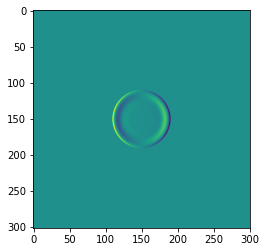

In [89]:
plt.imshow(conv1(output[None])[0,0].detach().numpy())

In [90]:
# Derivatives along y : to do two times recursively to compute dydy
y = np.array([[-1],[1]])

conv1=nn.Conv2d(1, 1, kernel_size=(2,1), stride=1, padding=1, bias=False)
conv1.weight=nn.Parameter(torch.from_numpy(y).float().unsqueeze(0).unsqueeze(0))

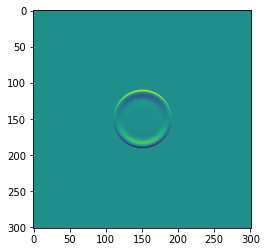

In [91]:
plt.imshow(conv1(output[None])[0,0].detach().numpy())

## Finite difference method : Residuals

In [107]:
class PINNLoss_RES(nn.Module):
    def __init__(self, dh=5, dt=0.002, c=2200, device='cuda:0'):
       super(PINNLoss_RES, self).__init__()

       # Parameters of the mesh
       self.dh = dh
       self.dt = dt
       self.c = c
       self.device = device

       self.P = (self.dt * self.c/self.dh) ** 2

       # Kernels filters
       # x FD
       self.weight_h = torch.FloatTensor([[[[ 0,  0,  0],[ 1, -2,  1],[ 0,  0,  0]]]]).to(self.device)
       # y FD
       self.weight_v = torch.FloatTensor([[[[ 0,  1,  0],[ 0, -2,  0],[ 0,  1,  0]]]]).to(self.device) 
       self.padding = _quadruple(1)

    def forward(self,fem_data):     

       u_n_preds = fem_data[:,:,-1:,:,:] # Predicitons by the NN
       u_n = fem_data[:,:,-2:-1,:,:]
       u_n_1 = fem_data[:,:,-3:-2,:,:]

       # Compute derivatives
       self.u_dxdx = F.conv2d(F.pad(u_n, padding, mode='circular'), weight_h, stride=1, padding=0, bias=None)
       self.u_dydy = F.conv2d(F.pad(u_n, padding, mode='circular'), weight_v, stride=1, padding=0, bias=None)   

       # PDE acoustic wave equation : 
       residuals = self.P * self.u_dxdx + self.P * self.u_dydy + 2 * u_n - u_n_1 - u_n_preds

       return torch.norm(residuals)

In [103]:
pinn_loss = PINNLoss_RES()

## Finite difference method : MSE

In [109]:
dh = 5
dt = 0.002

c = 2500

P = (dt ** 2) * (c ** 2)/(dh ** 2)

# x FD
x = np.array([[ 0,  0,  0],
              [ 1, -2,  1],
              [ 0,  0,  0]])

# y FD
y = np.array([[ 0,  1,  0],
              [ 0, -2,  0],
              [ 0,  1,  0]])

In [110]:
conv_x = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
conv_x.weight=nn.Parameter(torch.from_numpy(x).float().unsqueeze(0).unsqueeze(0))
conv_x = conv_x.to(device)

conv_y = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
conv_y.weight=nn.Parameter(torch.from_numpy(y).float().unsqueeze(0).unsqueeze(0))
conv_y = conv_y.to(device)

In [127]:
u_n = inputs[-1:,:,:][None].to(device)
u_n_1 = inputs[-2:-1,:,:][None].to(device)

In [128]:
u_dxdx = conv_x(u_n).cpu().detach().numpy()[0,0]
u_dydy = conv_y(u_n).cpu().detach().numpy()[0,0]

In [129]:
u_n = u_n.cpu().detach().numpy()[0,0]
u_n_1 = u_n_1.cpu().detach().numpy()[0,0]

In [130]:
next_u = P * u_dxdx + P * u_dydy + 2 * u_n - u_n_1

In [132]:
(next_u-output[0].detach().numpy()).min()

-44.86975

Text(0.5, 1.0, 'Error')

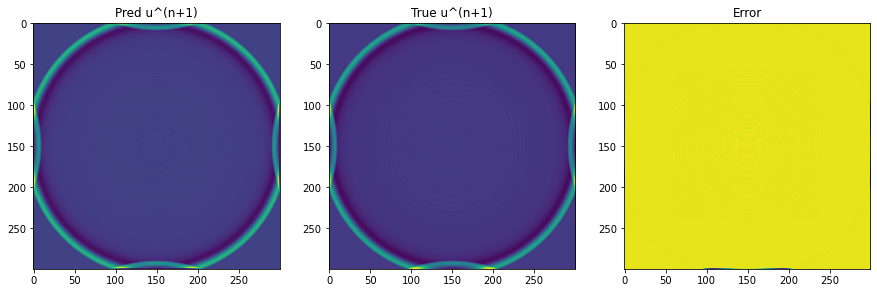

In [133]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(next_u)
ax[0].set_title('Pred u^(n+1)')
ax[1].imshow(output[0])
ax[1].set_title('True u^(n+1)')
ax[2].imshow(next_u-output[0].detach().numpy())
ax[2].set_title('Error')


In [117]:
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple

In [118]:
weight_h = torch.FloatTensor([[[[ 0,  0,  0],[ 1, -2,  1],[ 0,  0,  0]]]])
weight_v = torch.FloatTensor([[[[ 0,  1,  0],[ 0, -2,  0],[ 0,  1,  0]]]])

padding = _quadruple(1)

In [119]:
u_n = inputs[-1:,:,:][None]
u_n_1 = inputs[-2:-1,:,:][None]

In [120]:
u_dxdx = F.conv2d(F.pad(u_n, padding, mode='circular'), weight_h, stride=1, padding=0, bias=None)
u_dydy = F.conv2d(F.pad(u_n, padding, mode='circular'), weight_v, stride=1, padding=0, bias=None)

In [121]:
u_dxdx = u_dxdx.detach().cpu().numpy()[0,0]
u_dydy = u_dydy.detach().cpu().numpy()[0,0]

u_n = u_n.cpu().detach().numpy()[0,0]
u_n_1 = u_n_1.cpu().detach().numpy()[0,0]

next_u = P * u_dxdx + P * u_dydy + 2 * u_n - u_n_1

In [124]:
(next_u-output[0].detach().numpy()).min()

-2.0195932

Text(0.5, 1.0, 'Error')

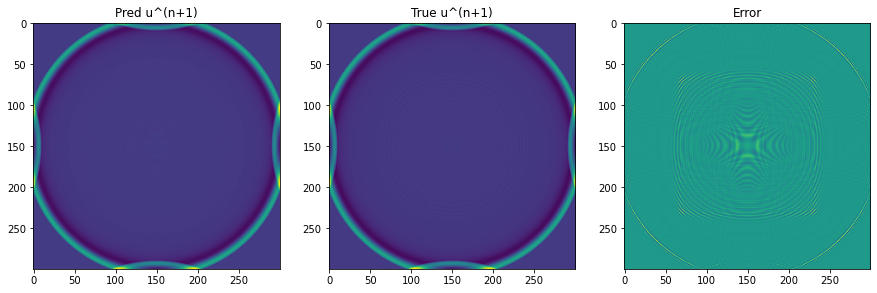

In [123]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(next_u)
ax[0].set_title('Pred u^(n+1)')
ax[1].imshow(output[0])
ax[1].set_title('True u^(n+1)')
ax[2].imshow(next_u-output[0].detach().numpy())
ax[2].set_title('Error')

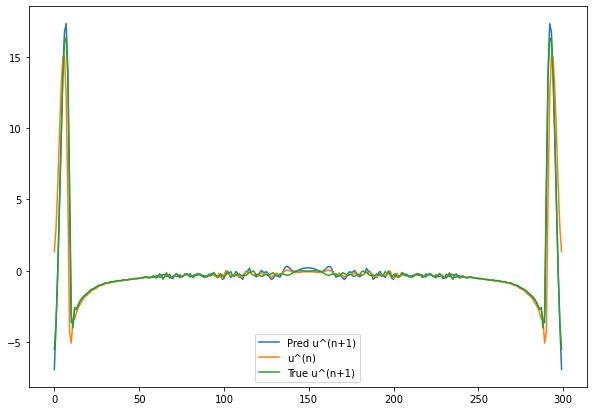

In [29]:
 fig, ax = plt.subplots(1,1,figsize=(10,7))

plt.plot(next_u[150,:],label='Pred u^(n+1)')
plt.plot(u_n[150,:],label='u^(n)')
plt.plot(output[0].detach().numpy()[150,:],label='True u^(n+1)')

plt.legend()

In [30]:
class PINNLoss_MSE(nn.Module):
    def __init__(self, dh=5, dt=0.002, c=2200, device='cpu'):
        super(PINNLoss_MSE, self).__init__()

        # Parameters of the mesh
        self.dh = dh
        self.dt = dt
        self.c = c
        self.device = device

        self.P = (self.dt ** 2) * (self.c ** 2)/(self.dh ** 2)

        # Kernels filters
        # x FD
        self.x = np.array([[ 0,  0,  0],
              [ 1, -2,  1],
              [ 0,  0,  0]])

        # y FD
        self.y = np.array([[ 0,  1,  0],
              [ 0, -2,  0],
              [ 0,  1,  0]])


        # u_dxdx
        self.conv_x = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv_x.weight=nn.Parameter(torch.from_numpy(self.x).float().unsqueeze(0).unsqueeze(0))
        self.conv_x = conv_x.to(device)

        # u_dydy
        self.conv_y = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv_y.weight=nn.Parameter(torch.from_numpy(self.y).float().unsqueeze(0).unsqueeze(0))
        self.conv_y = self.conv_y.to(device)


    def forward(self,inputs):
        """
        inputs : combination of inputs and outputs of the model, shape = (Minibatch,Channels,Width,Height)
        """    

        preds = inputs[:,-1:,:,:] # last from inputs (prediction from the NN)
        u_n = inputs[:,-2:-1,:,:] 
        u_n_1 = inputs[:,-3:-2,:,:]

        # Compute derivatives
        u_dxdx, u_dydy = self.conv_x(u_n), self.conv_y(u_n)

        # PDE acoustic wave equation : 
        next_u = P * u_dxdx + P * u_dydy + 2 * u_n - u_n_1

        return torch.mean(preds - next_u)

In [31]:
pinn_loss_mse = PINNLoss_MSE()

In [32]:
all_.shape

torch.Size([5, 300, 300])

In [33]:
pinn_loss_mse(all_[None])

tensor(0.0784, grad_fn=<MeanBackward0>)